In [794]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
import warnings
from sklearn.pipeline import make_pipeline
from mpl_toolkits import mplot3d
import yaml
from scipy.stats import pearsonr
import decimal
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from datetime import datetime
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot
import pickle



random_state = 2023

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

server_info = config["server"]

print(config)

2.9.0
{'server': {'name': 'localhost', 'user': 'sa', 'password': 'Passw0rd!', 'database': 'Loans_2023_01_27'}, 'model_dir': '../Models/', 'tables': [{'name': 'dbo.UnderwritingData', 'primary': 'VIN', 'secondary': 'CreaditScore', 'null_secondary': 0}, {'name': 'dbo.RawAlgorithmData', 'primary': 'Vin6', 'secondary': 'Score', 'null_secondary': 0}], 'predictions': {'target': 'ProcStatsCd', 'replace': {'CL': 1, 'CO': 0}, 'doSpecial': True, 'special': 'ProfitLoss'}, 'ignore': ['Class_', 'AccountShort', 'CustomerNumber', 'CurBalAmt', 'Customer', 'AdminStatus', 'ResultCD', 'ChargeOffDt', 'PercentageOfPaymentsMade', 'DelqCalcAlert', 'RecyCalcAlert', 'ApplicationNumber', 'CurrentPaymentsMade', 'Name', 'Delq'], 'outliers': {'ignore': ['Status', 'DelqPct', 'CreaditScore', 'HomeOwner', 'Reposessions', 'Chageoff', 'APR']}}


In [809]:
class DatabaseLoader:
    def __init__(self, _server_info):
        _conn = pymssql.connect(server=server_info['name'], user=server_info['user'], password=server_info['password'], database=server_info['database'])

        self._cursor = _conn.cursor()
        self._empty = True
        self.df = None
        self._global_primary = None
        self._global_secondary = None
        self._global_primary_type = None
        self._global_secondary_type = None
        self._target = None
        self._special_target = None

    def get_column_index(self, _column_name):
        for index, col in enumerate(self._cursor.description):
            if col[0] == _column_name:
                return index

    def replace_col_name(self, _cur_headers, _old, _new):
        for idx, header in enumerate(_cur_headers):
            if header==_old:
                _cur_headers[idx] = _new

    def load_tables(self, _tables, _ignore=None):
        for _table in _tables:
            self.load_table(_table, ignore=_ignore)


    def load_table(self, _table_info, ignore=None):
        if ignore is None:
            ignore = []
        self._cursor.execute("SELECT * FROM {table}".format(table=_table_info['name']))

        _headers = []
        _rows = []

        for entity in self._cursor.description:
            _headers.append(entity[0])

        _primary_index = self.get_column_index(_table_info['primary'])
        _secondary_index = self.get_column_index(_table_info['secondary'])

        _res = self._cursor.fetchone()
        while _res:
            _row = [element for element in _res]
            if _row[_primary_index] is not None and _row[_primary_index].strip() != "n/a" and _row[_secondary_index] != _table_info['null_secondary']:
                # Strips trailing whitespace from strings
                for _idx, item in enumerate(_row):
                    if isinstance(item, str):
                        _row[_idx] = item.strip()

                    if isinstance(item, decimal.Decimal):
                        _row[_idx] = float(item)

                _rows.append(_row)
            _res = self._cursor.fetchone()

        if self._empty:
            self._empty = False
            self.df = pd.DataFrame(_rows, columns=_headers)
            self._global_primary = _table_info['primary']
            self._global_secondary = _table_info['secondary']
            self._global_primary_type = type(self.df[self._global_primary].iloc[0])
            self._global_secondary_type = type(self.df[self._global_secondary].iloc[0])
        else:
            # Replace the primary and secondary key column names with the global primary and secondary key names
            self.replace_col_name(_headers, _table_info['primary'], self._global_primary)
            self.replace_col_name(_headers, _table_info['secondary'], self._global_secondary)

            temp_df = pd.DataFrame(_rows, columns = _headers)
            # Cast the primary and secondary keys to global type
            temp_df[self._global_primary] = temp_df[self._global_primary].astype(self._global_primary_type)
            temp_df[self._global_secondary] = temp_df[self._global_secondary].astype(self._global_secondary_type)

            self.df = pd.merge(temp_df, self.df, how = 'inner', on=['VIN', 'CreaditScore'])

        # Remove any columns to ignore
        self.df = self.df.drop(labels = ignore, axis=1, errors='ignore')

    def dropna(self):
        #Drop any rows with NaN values
        self.df.dropna(how='any', inplace=True)

    def move_col_to_end(self, col):
        _cols = list(self.df.columns)
        _cols.remove(col)
        _cols.append(col)
        self.df = self.df[_cols]

    def prune_for_target(self, _prediction_info):
        self._target = _prediction_info['target']
        _replace_guide = _prediction_info['replace']

        self.df = self.df[self.df[self._target].isin(list(_replace_guide.keys()))]
        for key, value in _replace_guide.items():
            self.df[self._target].replace(to_replace=key, value=value, inplace=True)

        # Move the target to the end of the dataframe
        _cols = list(self.df.columns)
        _cols.remove(self._target)
        _cols.append(self._target)
        self.df = self.df[_cols]

        if _prediction_info['doSpecial']:
            if _prediction_info['special'] == 'DelqPct':
                self.df = self.df[self.df['OpeningBalance']!=0]
                self.df['DelqPct'] = self.df.apply(lambda _row : (100 * _row['Delq']) / _row['OpeningBalance'], axis=1)

                # Remove the old target and Delq from the dataframe
                _cols = list(self.df.columns)
                _cols.remove(self._target)
                _cols.remove("Delq")
                self.df = self.df[_cols]
                self._target = "DelqPct"
            elif _prediction_info['special'] == 'ProfitLoss':
                self.df['PaidForLoan'] = self.df.apply(lambda _row: _row['OpeningBalance'] - (_row['OpeningBalance']*.15), axis = 1)
                self.df['PL'] = self.df.apply(lambda _row: _row['NumberPmnt']*_row['Payment'] - _row['PaidForLoan'], axis=1)


    def remove_majority_null(self, threshold = .7):
        total = len(self.df)
        cols_to_drop = []
        percents = []
        for column in self.df.columns:
            non_null_count = 0
            for _idx, item in self.df[column].items():
                if item is not None:
                    non_null_count +=1
            percent = float(non_null_count)/float(total)
            if percent < threshold:
                cols_to_drop.append(column)
                percents.append((1-percent)*100)

        self.df = self.df.drop(cols_to_drop, axis = 1)
        for _idx, column in enumerate(cols_to_drop):
            print("Dropping {column} since {percent}% of entires were Null".format(column=column, percent = percents[_idx]))

    def contains_null_or_is_categorical(self, series):
        if self.is_categorical(series):
            return True

        for _idx, item in series.items():
            if item is None:
                return True

        return False

    @staticmethod
    def get_type_series(series):
        for _idx, item in series.items():
            if item is not None:
                return type(item)
        return None

    def is_categorical(self, series):
        return self.get_type_series(series) == str

    def get_correlated_entities(self, threshold = 0.1, inplace= False):
        corrs = dict()
        print("Computing Entity Correlations")
        for col in tqdm(self.df.columns):
            if col == self._target or self.contains_null_or_is_categorical(self.df[col]):
                continue
            corr, _ = pearsonr(self.df[col], self.df[self._target])
            corrs[col] = abs(corr)

        corrs = {_k: _v for _k, _v in sorted(corrs.items(), key=lambda item: item[1])}

        goodCols = []

        for col, score in corrs.items():
            if score>=threshold:
                goodCols.append(col)

        print(goodCols)

        if inplace:
            goodCols.append(self._target)
            self.df = self.df[goodCols]
        else:
            return self.df[goodCols]

    def remove_outliers(self, lower_thresh = 0.00, upper_thresh = 0.999, ignore=None):
        if ignore is None:
            ignore = []
        for col in self.df.columns:
            if col in ignore or col==self._target or self.is_categorical(self.df[col]):
                continue
            percentiles = self.df[col].quantile([lower_thresh, upper_thresh]).values
            self.df.loc[self.df[col]<=percentiles[0], col] = percentiles[0]
            self.df.loc[self.df[col]>=percentiles[1], col] = percentiles[1]

    def get_target_col(self):
        return self.df[self._target]

    def get_categorical_vars(self):
        cats = []
        for col in self.df.columns:
            if self.is_categorical(self.df[col]):
                cats.append(col)
        return cats

    def one_hot(self, inplace = False):
        cat_attribs = self.get_categorical_vars()
        full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')
        encoder = full_pipeline.fit(self.df)
        if inplace:
            self.df = encoder.transform(self.df)
        else:
            return encoder.transform(self.df)

    def one_hot_dummies(self, inplace=False):
        cat_attribs = self.get_categorical_vars()
        temp_df = self.df.copy(deep=True)
        print("One Hot Encoding")
        for cat in tqdm(cat_attribs):
            one_hot = pd.get_dummies(self.df[cat])
            for i in one_hot.columns:
                new_name = cat+i
                new_name = new_name.replace("[", "")
                new_name = new_name.replace("]", "")
                new_name = new_name.replace("<", "")
                one_hot.rename(columns={i:new_name}, inplace=True)
            temp_df = temp_df.drop(cat, axis=1)
            temp_df = pd.concat([temp_df, one_hot], axis=1)

        if inplace:
            self.df = temp_df
            self.move_col_to_end(self._target)
        else:
            return temp_df

    def get_df_no_categoricals(self):
        return self.df.drop(self.get_categorical_vars(), axis=1)

    def get_df_highest_category(self, category, only_quantitative = True):
        counts = defaultdict(int)

        for item in self.df[category]:
            counts[item] += 1

        counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

        highest = list(counts.keys())[0]
        print("Training on {item}".format(item=highest))

        if only_quantitative:
            return self.df[self.df[category]==highest].drop(self.get_categorical_vars(), axis=1)
        else:
            return self.df[self.df[category]==highest]

    def standardize_categorical_column(self, col, inplace=False):
        if inplace:
            self.df[col] = self.df[col].apply(lambda x: x.replace("0", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("8", "").replace(" ", ""))
        else:
            return self.df[col].apply(lambda x: x.replace("0", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("8", "").replace(" ", ""))

    def print_cols(self):
        for col in self.df.columns:
            print(col)

    def print_model_stats(self, y_test, preds):
        # print("Preds")
        # print(preds[:10])
        # print("Actual")
        # print(y_test[:10])
        print("Confusion Matrix: ")
        print(confusion_matrix(y_test, preds))
        print("Accuracy: ")
        print(accuracy_score(y_test, preds))
        print("F1: ")
        print(f1_score(y_test,preds))

    @staticmethod
    def print_feature_importance(_model):
        _importance = _model.feature_importances_
        # summarize feature importance
        print("Feature Importance: ")
        for i,v in enumerate(_importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        # plot feature importance
        pyplot.bar([x for x in range(len(_importance))], _importance)
        pyplot.show()

    @staticmethod
    def get_model_name(_model, y_test, preds, model_name=""):
        _acc = accuracy_score(y_test, preds)
        cur = datetime.now().strftime("%D:%H:%M").replace("/", "-").replace(":", "_", 1).replace(":", "-")

        return "{model_name}_{cur}-{acc}%.pkl".format(model_name=model_name, cur=cur, acc=round(_acc, 3))

    def train_model(self, _model, use_categoricals = False, print_stats = False, print_feature_importance = False, save = False, save_dir="../Models/", model_name="model.pkl"):
        data = None
        if use_categoricals:
            data = self.df.copy(deep=True)
        else:
            data = self.get_df_no_categoricals().copy(deep=True)

        xtrain, xtest, ytrain, ytest = train_test_split(data.iloc[:, :-1], data.iloc[:, -1:], test_size = 0.2)

        _model.fit(xtrain, ytrain)

        preds = _model.predict(xtest)

        if print_stats:
            self.print_model_stats(ytest, preds)

        if print_feature_importance:
            self.print_feature_importance(_model)

        if save:
            # filename = self.get_model_name(model, y_test, preds, model_name=model_name)
            filename=model_name
            print("Saving: {filename}".format(filename=filename))
            pickle.dump(_model, open(filename, 'wb+'))

            # Save a model config file
            conf = dict()
            trained_entities = list(xtrain.columns)
            conf['entities'] = trained_entities

            with open("model_config.yaml", 'w+') as yamlfile:
                yaml.dump(conf, yamlfile)
                print("Model config write successful")

    def run_model(self, model_name="model.pkl", use_categoricals = False):
        _model = pickle.load(open(model_name, 'rb'))
        with open("model_config.yaml") as f:
            model_config = yaml.load(f, Loader=yaml.FullLoader)

        input_data = None
        if use_categoricals:
            input_data = self.df.copy(deep=True)
        else:
            input_data = self.get_df_no_categoricals().copy(deep=True)

        # Drop all entities not used during training
        input_data=input_data[model_config['entities']]

        #drop all rows containing na
        input_data.dropna(how='any', inplace=True)

        input_data["Prediction"] = _model.predict(input_data)

        return input_data


In [811]:
dbl = DatabaseLoader(server_info)

dbl.load_tables(config['tables'], config['ignore'])
dbl.prune_for_target(config['predictions'])
dbl.remove_majority_null() #removes columns where a majority of entries are null
dbl.dropna() #removes all rows that have NA values. Do this after remove_majority_null
dbl.remove_outliers(ignore = config['outliers']['ignore'])
# dbl.one_hot_dummies(True)

print(dbl.get_df_no_categoricals()["Payment"])
print(dbl.get_df_no_categoricals().columns)


Dropping Discount since 100.0% of entires were Null
Dropping CustomScore since 44.51843043995244% of entires were Null
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
13108    0.0
13120    0.0
13140    0.0
13164    0.0
13213    0.0
Name: Payment, Length: 7244, dtype: float64
Index(['NumberPmnt', 'CreaditScore', 'Salary_x', 'Recy', 'OrigTerm', 'Apr',
       'OpeningBalance', 'Salary_y', 'EmploymentMonths', 'Term', 'Payment',
       'PTI', 'VehicleYear', 'APR', 'LTV', 'DTI', 'Mileage', 'TradelinesTotal',
       'TradelinesBalance', 'Foreclosure', 'Reposessions', 'Bankrupcies',
       'Chageoff', 'Mortgage', 'NinetyDaysDelinquent', 'Was180DaysPastDue',
       'Account150DaysPastDue', 'Account180DaysPastDue', 'InquiresTotal',
       'OpenTotal', 'ClosedTotalTermsNotPaid', 'LatePaymentHistory001230',
       'LatePaymentHistory001260', 'LatePaymentHistory001290Plus',
       'LatePaymentHistory132430', 'LatePaymentHistory132460',
       'LatePaymentHistory132490P

In [782]:
warnings.simplefilter(action='ignore', category=FutureWarning)


model = RandomForestClassifier(n_estimators = 1000)

df = dbl.get_df_no_categoricals()

xtrain, xtest, ytrain, ytest = train_test_split(df.iloc[:, :-1], df.iloc[:, -1:], test_size = 0.2)

model.fit(xtrain, ytrain)

preds = model.predict(xtest)
ytest = ytest["ProcStatsCd"].values

corlabels = []

correct =pd.DataFrame()

for i in tqdm(range(len(preds))):
    pred = preds[i]
    label = ytest[i]

    if pred==label:
        # correct = pd.concat([correct, xtest.iloc[i]])
        correct = correct.append(xtest.iloc[i])
        corlabels.append(pred)

print(correct)


100%|██████████| 1263/1263 [00:00<00:00, 4512.02it/s]

       CreaditScore  Salary_x    Recy  OrigTerm    Apr  OpeningBalance  \
10431         570.0    2236.0   138.0      48.0  24.90        11900.00   
11981         538.0    2857.8   375.0      50.0  23.99        11594.43   
4218          572.0    3600.0   362.0      42.0  20.99        10853.03   
2447          573.0       0.0   592.0      54.0  21.95        14614.68   
11688         489.0    1542.0   509.0      36.0  24.00         7295.00   
...             ...       ...     ...       ...    ...             ...   
2330          494.0    1381.0   344.0      48.0  19.95        17650.26   
872           465.0    4000.0   759.0      28.0  24.99         5407.77   
9666          538.0   16000.0   217.0      30.0  18.99         6561.41   
10926         554.0       0.0  1169.0      54.0  18.00        16390.00   
10924         497.0    2023.0   916.0      48.0  24.00        10422.00   

       Salary_y  EmploymentMonths  Term  Payment  ...  \
10431    2233.0               0.0  48.0      0.0  ... 

       CreaditScore      Salary_x         Recy    OrigTerm         Apr  \
count    809.000000    809.000000   809.000000  809.000000  809.000000   
mean     553.405439   2974.103807   629.275649   44.892460   22.637701   
std       59.260219   2458.691557   388.158309    7.385901    2.254617   
min      400.000000      0.000000     1.000000   12.000000   12.990000   
25%      513.000000   2000.000000   298.000000   42.000000   21.200000   
50%      548.000000   2580.000000   593.000000   48.000000   22.950000   
75%      581.000000   3444.520000   943.000000   48.000000   24.900000   
max      840.000000  27570.000000  1579.000000   60.000000   29.990000   

       OpeningBalance      Salary_y  EmploymentMonths        Term  Payment  \
count      809.000000    809.000000             809.0  809.000000    809.0   
mean     10691.406119   3100.799753               0.0   44.903585      0.0   
std       3073.375077   1766.524367               0.0    7.385301      0.0   
min       3872.730000

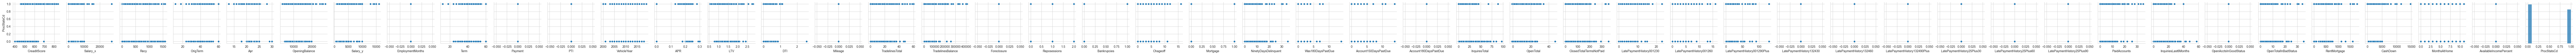

In [781]:
print(correct.describe())
correct["ProcStatsCd"] = corlabels
xvars = correct.columns
xvars.drop("ProcStatsCd")
sns.pairplot(data=correct,
                  y_vars="ProcStatsCd",
                  x_vars=xvars)

       CreaditScore      Salary_x         Recy     OrigTerm          Apr  \
count   6315.000000   6315.000000  6315.000000  6315.000000  6315.000000   
mean     550.556611   2923.161153   610.503739    44.837846    22.598415   
std       55.568041   2065.943399   381.788931     7.274255     2.223595   
min      400.000000      0.000000     1.000000    12.000000    10.990000   
25%      511.000000   2000.000000   287.000000    42.000000    21.000000   
50%      547.000000   2600.000000   566.000000    48.000000    22.950000   
75%      581.000000   3500.000000   913.000000    48.000000    24.900000   
max      840.000000  27570.000000  1614.056000    60.000000    29.990000   

       OpeningBalance      Salary_y  EmploymentMonths         Term  Payment  \
count     6315.000000   6315.000000            6315.0  6315.000000   6315.0   
mean     10681.382285   3118.992158               0.0    44.835946      0.0   
std       3029.739090   1723.855002               0.0     7.278587      0.0   

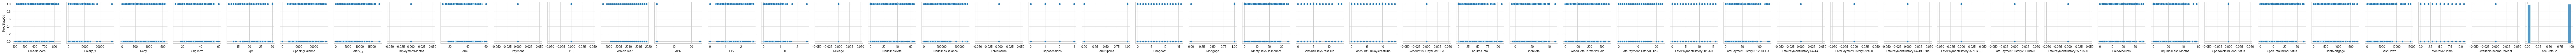

In [777]:
print(df.describe())
xvars = df.columns
xvars.drop("ProcStatsCd")
sns.pairplot(data=df,
                  y_vars="ProcStatsCd",
                  x_vars=xvars)

In [ ]:
model = RandomForestClassifier(n_estimators = 1000)
dbl.train_model(model, print_stats = True, save = True)

In [696]:
# Now pretend we load data with no labels (i.e. customers that we want to predict)
testdbl = DatabaseLoader(server_info)
# We still need to load all the tables that contain the entities
testdbl.load_tables(config['tables'], config['ignore'])
# We do not need to call prune for target (since the target should not exist in the database)

# Now, we can run the model, which will append a prediction to customer
testdf = testdbl.run_model("model.pkl")

print(testdf)

       CreaditScore  Salary_x  Recy  OrigTerm    Apr  OpeningBalance  \
0               676    600.00   490        42  20.98         8231.24   
1               532   9026.33   400        48  22.99        13048.40   
2               531   2800.00   165        48  24.99         8704.21   
3               572   2000.00    70        48  22.00        11913.48   
4               513   4533.00   293        48  22.95        11375.39   
...             ...       ...   ...       ...    ...             ...   
13209           777   2500.00     4        52  21.00        14339.00   
13210           601   2786.00     1        54  20.00        12983.58   
13211           540   2800.00     1        42  23.90        10536.57   
13212           512   2850.00  1287        48  24.90        11500.00   
13213           462   4300.00  1413        52  19.90        16001.94   

       Salary_y  EmploymentMonths  Term  Payment  ...  \
0        1600.0                 0    42      0.0  ...   
1        4604.0      

## Ensemble Filtering

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

epochs = 10
num_models = 10

filter = dbl.get_df_no_categoricals().copy(deep=True).head(6000)

initIds= [i for i in range(len(filter))]
filter["ID"] = initIds

cols = list(filter.columns)
cols.remove("ProcStatsCd")
cols.append("ProcStatsCd")
filter = filter[cols]


num_removed = 0

for i in range(epochs):
    models = []
    for n in tqdm(range(num_models)):
        x_train, x_test, y_train, y_test = train_test_split(filter.iloc[:,:-2], filter.iloc[:,-1:], test_size=1.0-(1.0/num_models))

        # Instantiate model with 1000 decision trees
        rf = RandomForestClassifier(n_estimators = 10)
        # Train the model on training data
        rf.fit(x_train.values, y_train.values)

        models.append(rf)

    for idx, row in filter.iterrows():
        curId = row["ID"]
        dp = row.iloc[:-2]
        y = int(row.iloc[-1:]['ProcStatsCd'])
        correct = 0
        for model in models:
            pred = model.predict(dp.values.reshape(1, -1))
            if pred[0]==y:
                correct +=1

        if correct<(num_models/2):
            #Remove this data point from the training set
            filter = filter[filter["ID"]!=curId]
            print("Removing {id}".format(id=curId))
            num_removed+=1
print(filter)



[0 1 0 0 1 0 1 0 0 0]
    ProcStatsCd
0             1
1             1
4             1
5             0
8             1
9             0
15            0
18            0
19            1
20            0
       CreaditScore  Salary_x    Recy  OrigTerm    Apr  OpeningBalance  \
10003           467    2400.0   587.0        32  24.00         7773.89   
10004           540    8000.0   412.0        48  24.00        12028.24   
10005           513       0.0   110.0        48  24.90        13995.00   
10007           610    3000.0   657.0        42  24.00         9503.21   
10009           510    3960.0   184.0        54  18.00        10046.99   
...             ...       ...     ...       ...    ...             ...   
13140           516    7000.0    18.0        54  18.99        12423.17   
13164           580    3000.0    29.0        46  22.90        11500.00   
13167           566    3640.0    30.0        48  21.90        14700.00   
13212           512    2850.0  1287.0        48  24.90        

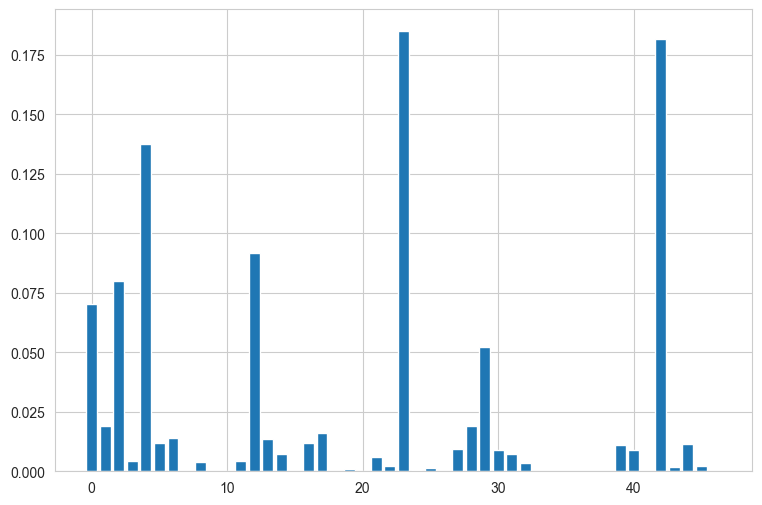

In [484]:
test = dbl.get_df_no_categoricals().copy(deep=True).tail(2000)
testX = test.iloc[:,:-1]
testy = test.iloc[:,-1:]

#has to be -2 since filter has an ID
trainX = filter.iloc[:,:-2]
trainy = filter.iloc[:,-1:]

rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(trainX, trainy)

preds = rf.predict(testX)

print(preds[:10])
print(trainy[:10])
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot

print(testX)

print(confusion_matrix(testy, preds))
# Display accuracy score
print(accuracy_score(testy, preds))
# Display F1 score
print(f1_score(testy,preds))

importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## XGBoost

In [410]:
xgdata = dbl.df.copy(deep=True)

accs = []
for x in tqdm(range(3)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
    test = xgb.DMatrix(x_test, label=y_test, enable_categorical=True)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    # model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

    print("Acc: ", end='')
    print(acc)

    accs.append(acc)

    pred = model.predict(xgb.DMatrix(x_test))
    print("Preds")
    print(pred[:10])
    print("Test")
    print(y_test[:10])

print(sum(accs)/len(accs))

  0%|          | 0/3 [04:44<?, ?it/s]


KeyboardInterrupt: 

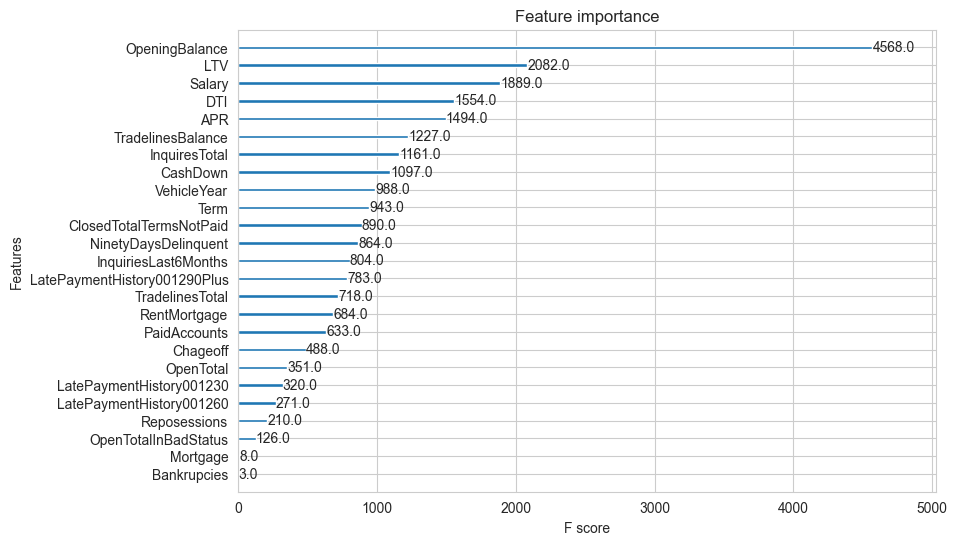

In [180]:
xgb_ml = xgb.Booster()

xgb_ml.load_model('Models/Delq/XGBoost_6.765%_Scorelate.json')
# x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
# print(xgb_ml.predict(xgb.DMatrix(x_test[:5])))
# print(y_test[:5])

# plot feature importance
plot_importance(xgb_ml)
plt.show()

In [365]:
res = xgb_ml.predict(xgb.DMatrix(x_test))
preds = []
actual = []
for pred in res:
    if(pred<3.5):
        preds.append("Paid")
    else:
        preds.append("CO")

for result in y_test["DelqPct"]:
    if result == 0.0:
        actual.append("Paid")
    else:
        actual.append("CO")

paidandpredpaid = 0
paidandpredco = 0
coandpredpaid = 0
coandpredco = 0

avgPaid = []
avgCO = []

for i in range(len(preds)):
    if preds[i]=="Paid" and actual[i]=="Paid":
        paidandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="Paid":
        paidandpredco+=1
    elif preds[i]=="Paid" and actual[i]=="CO":
        coandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="CO":
        coandpredco+=1
    if(actual[i]=="Paid"):
        avgPaid.append(res[i])
    else:
        avgCO.append(res[i])

print("Paid and Pred Paid: ", paidandpredpaid)
print("Paid and Pred CO: ", paidandpredco)
print("CO and Pred Paid: ", coandpredpaid)
print("CO and Pred CO: ", coandpredco)

print("Avg Paid: ", sum(avgPaid)/len(avgPaid))
print("Avg CO: ", sum(avgCO)/len(avgCO))

NameError: name 'xgb_ml' is not defined